In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libs

In [2]:
!apt-get install -y python3-fbprophet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-fbprophet


In [16]:
import logging
import cmdstanpy

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
from prophet import Prophet

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression

In [5]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

# Load data

In [25]:
sku_df = pd.read_csv(r'/content/drive/My Drive/DDH_2024/2_Task/data/raw/sku_dict.csv', parse_dates=['creation_date', 'expiration_date'])
ZX10208_df = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/ZX10208_agr.csv', parse_dates=['dates'])
df_1510001 = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/1510001_agr.csv', parse_dates=['dates'])
df_1510002 = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/1510002_agr.csv', parse_dates=['dates'])
df_1510003 = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/1510003_agr.csv', parse_dates=['dates'])
promo_1510002 = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/promo_1510002.csv', parse_dates=['year'])
conc_df = pd.read_csv('/content/drive/My Drive/DDH_2024/2_Task/data/raw/conc_df.csv', parse_dates=['year'])

In [82]:
ZX10208_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          259 non-null    datetime64[ns]
 1   SKU            259 non-null    int64         
 2   price_per_sku  181 non-null    float64       
 3   num_purchases  259 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 8.2 KB


In [83]:
df_1510001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940 entries, 0 to 3939
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          3940 non-null   datetime64[ns]
 1   SKU            3940 non-null   int64         
 2   price_per_sku  3940 non-null   float64       
 3   num_purchases  3940 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 123.2 KB


In [84]:
df_1510002.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          3840 non-null   datetime64[ns]
 1   SKU            3840 non-null   int64         
 2   price_per_sku  3840 non-null   float64       
 3   num_purchases  3840 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 120.1 KB


In [85]:
df_1510003.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          2851 non-null   datetime64[ns]
 1   SKU            2851 non-null   int64         
 2   price_per_sku  2851 non-null   float64       
 3   num_purchases  2851 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 89.2 KB


In [86]:
promo_1510002.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   year      52 non-null     datetime64[ns]
 1   week_num  52 non-null     int64         
 2   SKU       52 non-null     int64         
 3   discount  52 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.8 KB


In [87]:
conc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SKU            3009 non-null   int64         
 1   year           3009 non-null   datetime64[ns]
 2   week_num       3009 non-null   int64         
 3   ret_net_code   3009 non-null   int64         
 4   price_per_sku  3009 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 117.7 KB


# Preprocessing

In [26]:
for df in [ZX10208_df, df_1510001, df_1510002, df_1510003, promo_1510002, conc_df]:
  df.drop_duplicates(inplace=True)
  df.reset_index(drop=True, inplace=True)

# Заполнение по линейке для будущего обучения линейной модели эластичности
ZX10208_df['price_per_sku']=ZX10208_df['price_per_sku'].interpolate(method='linear')

In [27]:
ZX10208_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          259 non-null    datetime64[ns]
 1   SKU            259 non-null    int64         
 2   price_per_sku  259 non-null    float64       
 3   num_purchases  259 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 8.2 KB


# Analysis

<Axes: xlabel='dates', ylabel='price_per_sku'>

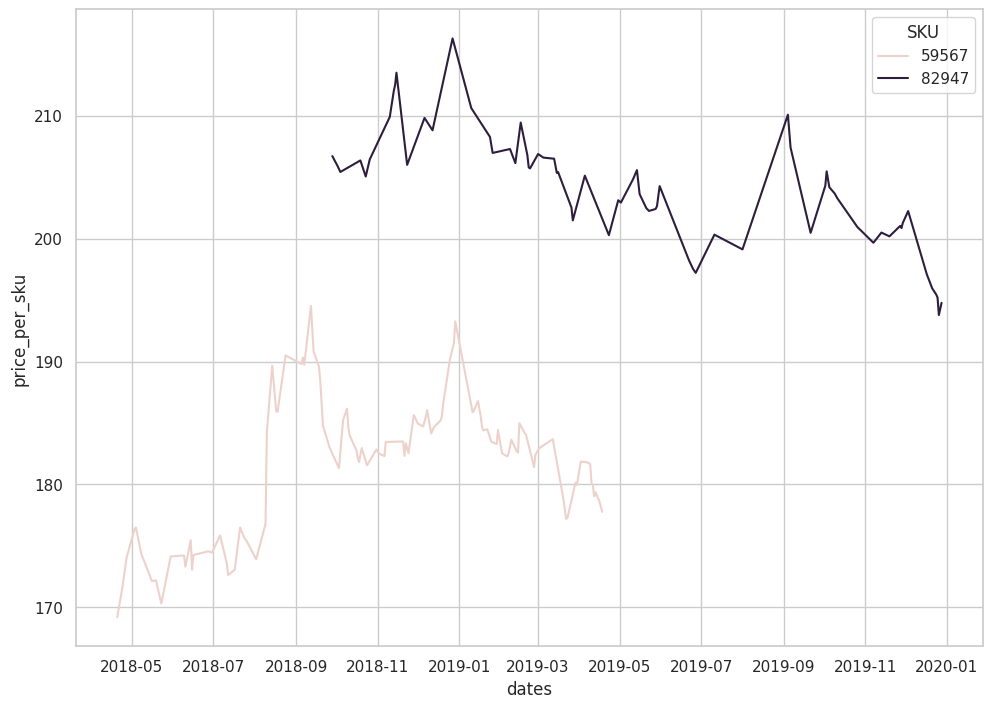

In [ ]:
sns.lineplot(data=ZX10208_df, x="dates", y="price_per_sku", hue='SKU')

<Axes: xlabel='dates', ylabel='num_purchases'>

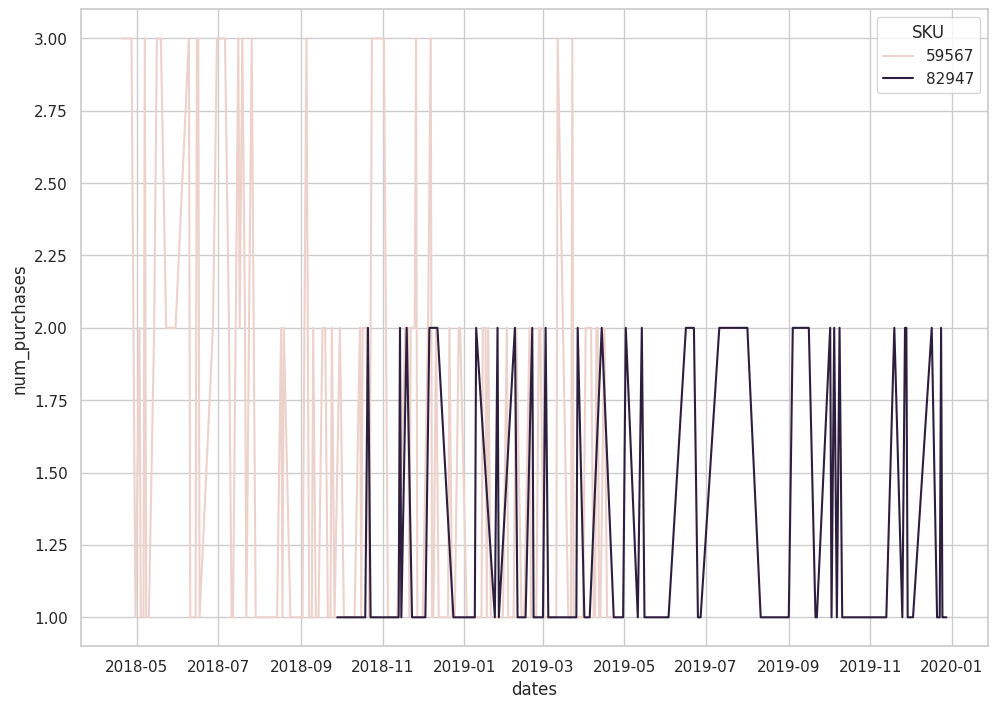

In [ ]:
sns.lineplot(data=ZX10208_df, x="dates", y="num_purchases", hue='SKU')

<Axes: xlabel='num_purchases', ylabel='price_per_sku'>

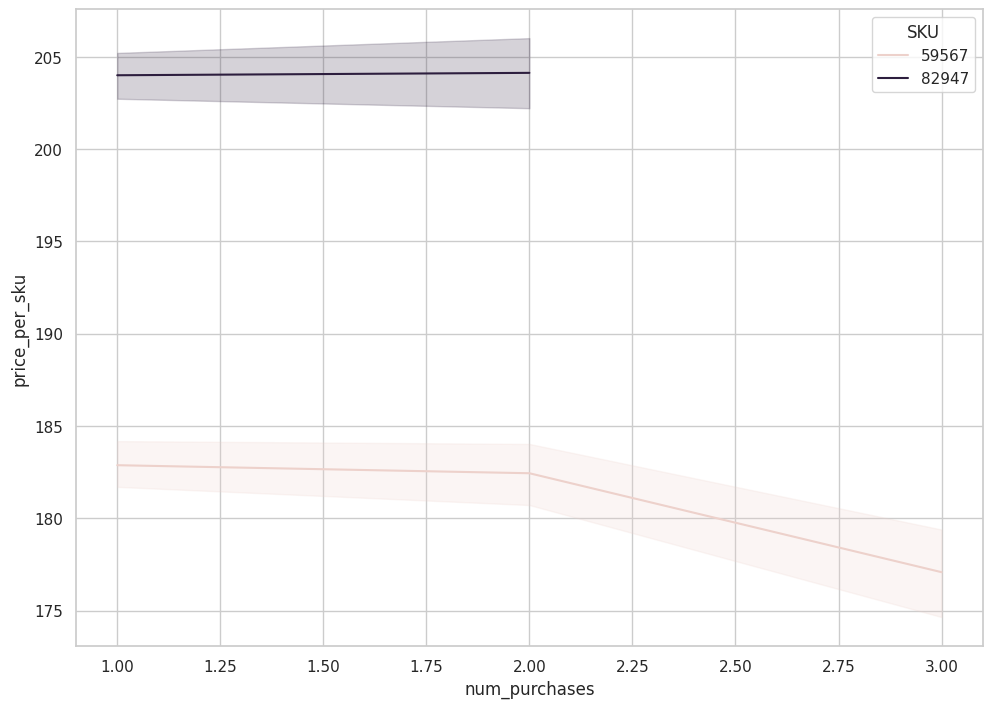

In [ ]:
sns.lineplot(data=ZX10208_df, x="num_purchases", y="price_per_sku", hue='SKU')

<Axes: xlabel='dates', ylabel='price_per_sku'>

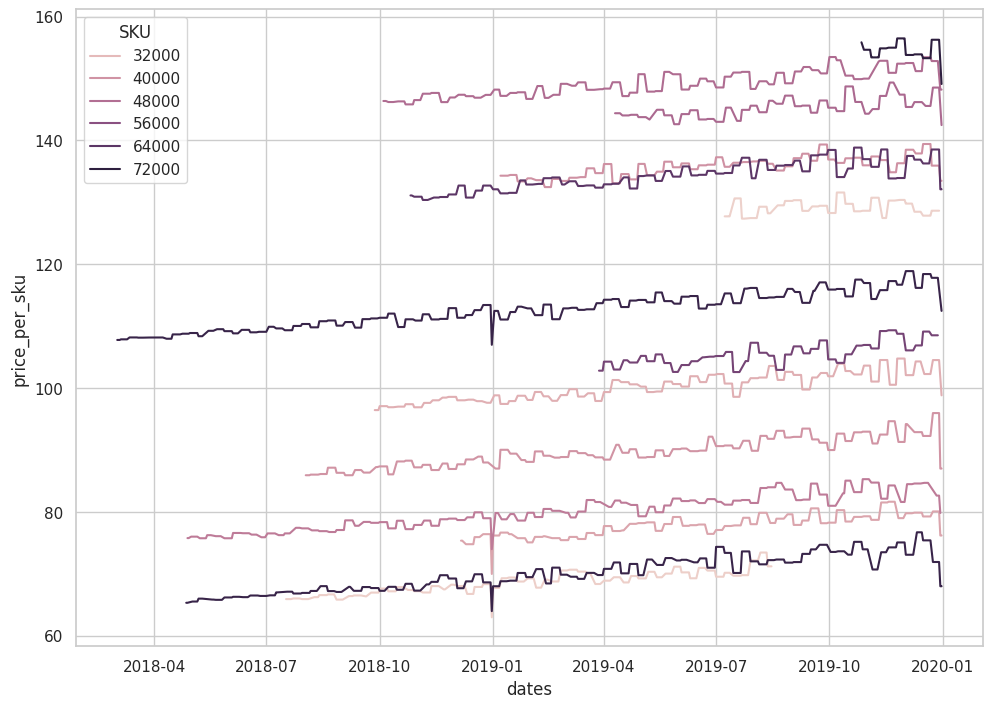

In [ ]:
sns.lineplot(data=df_1510001, x="dates", y='price_per_sku', hue='SKU')

<Axes: xlabel='dates', ylabel='num_purchases'>

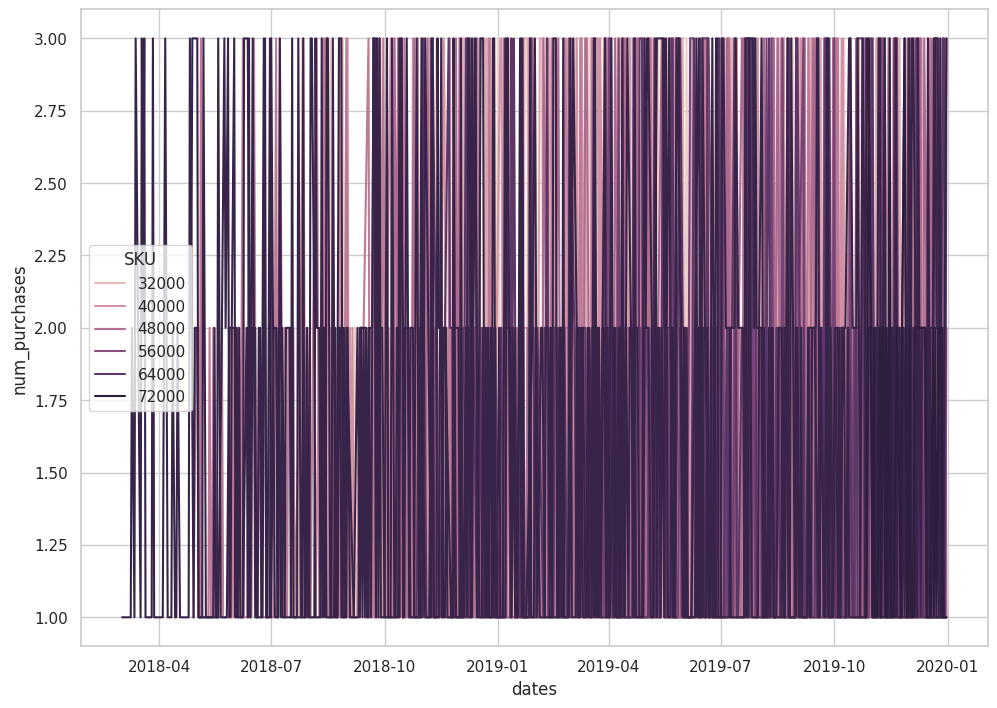

In [ ]:
sns.lineplot(data=df_1510001, x="dates", y="num_purchases", hue='SKU')

<Axes: xlabel='num_purchases', ylabel='price_per_sku'>

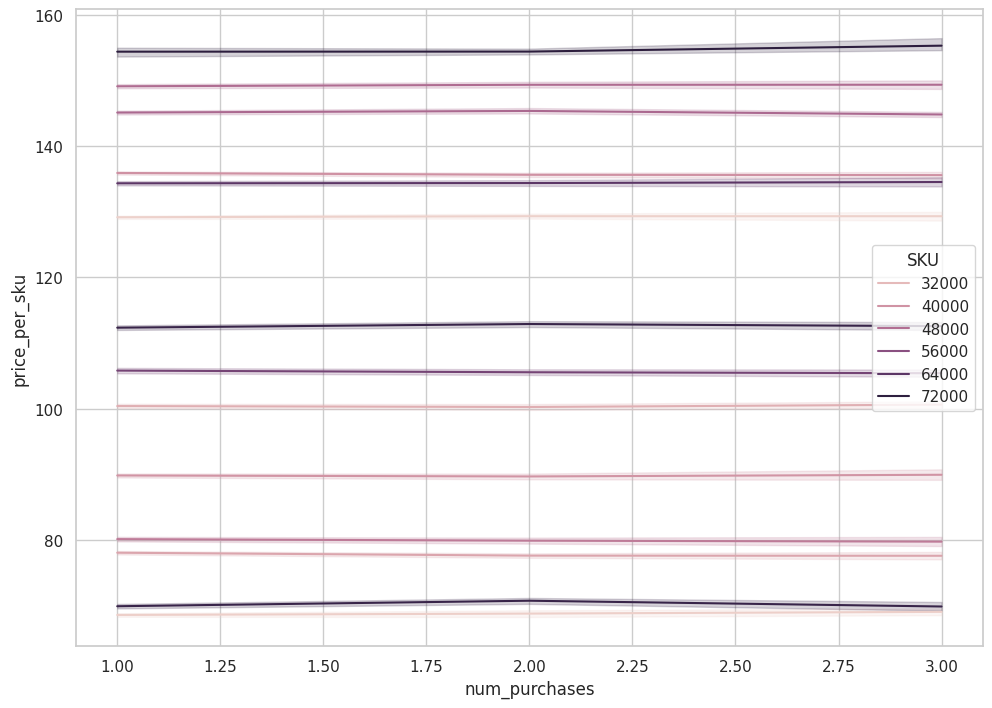

In [ ]:
sns.lineplot(data=df_1510001, x="num_purchases", y='price_per_sku', hue='SKU')

<Axes: xlabel='dates', ylabel='price_per_sku'>

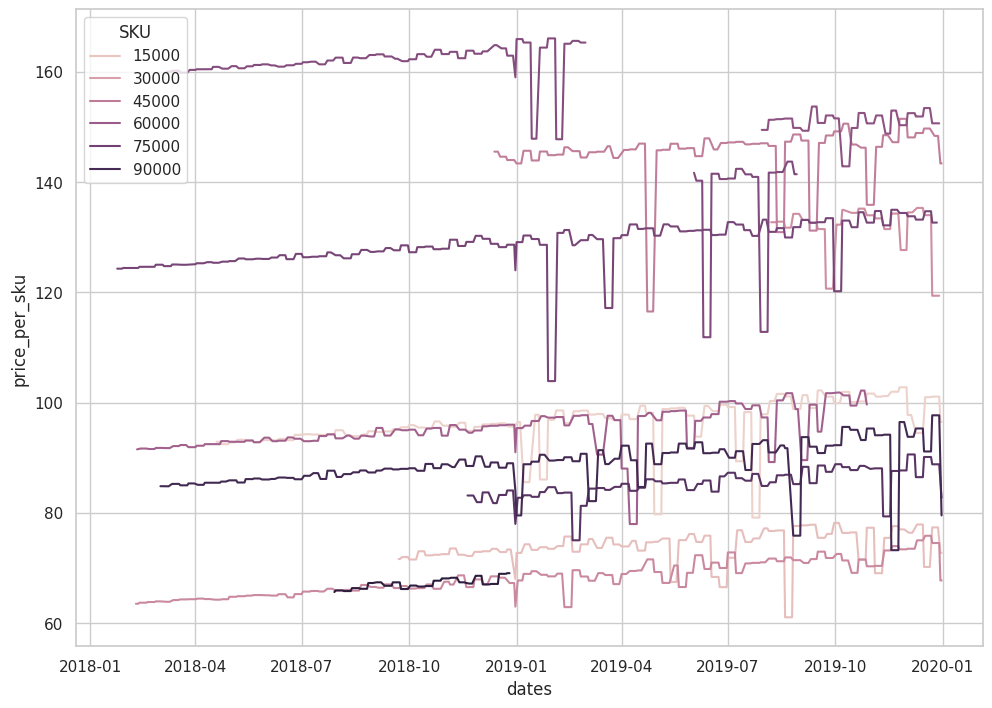

In [ ]:
sns.lineplot(data=df_1510002, x="dates", y='price_per_sku', hue='SKU')

<Axes: xlabel='dates', ylabel='num_purchases'>

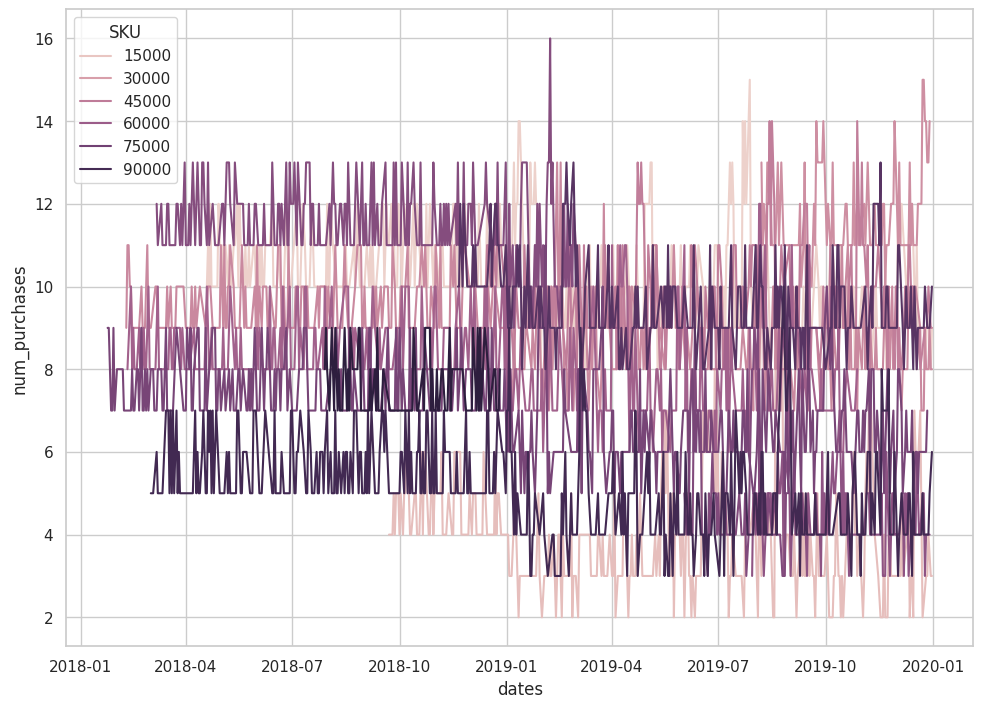

In [ ]:
sns.lineplot(data=df_1510002, x="dates", y="num_purchases", hue='SKU')

<Axes: xlabel='num_purchases', ylabel='price_per_sku'>

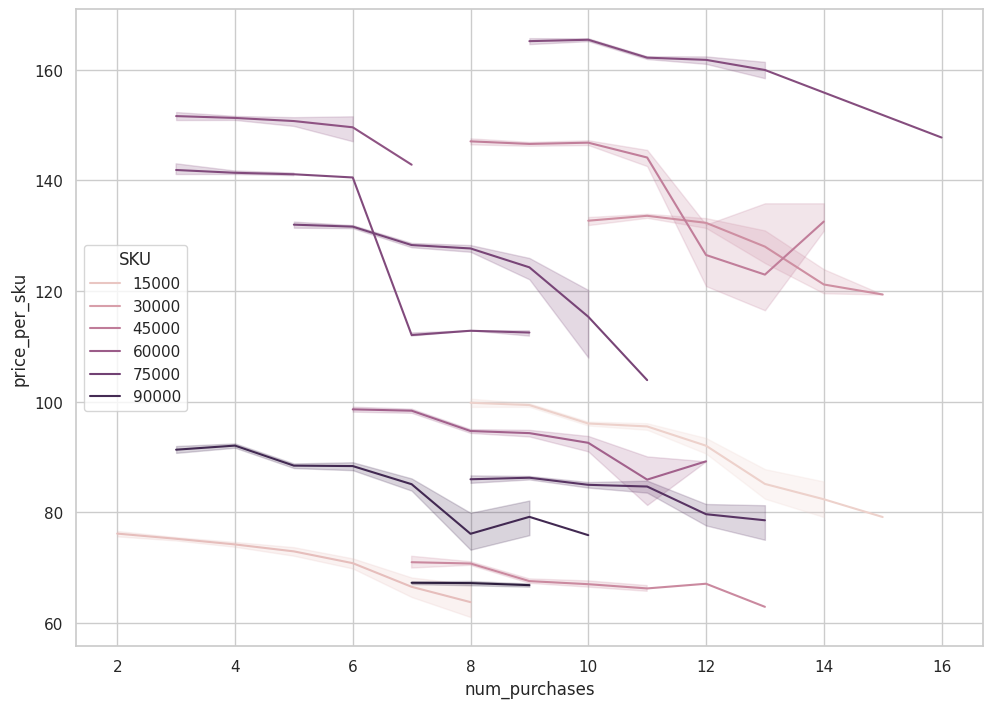

In [ ]:
sns.lineplot(data=df_1510002, x="num_purchases", y='price_per_sku', hue='SKU')

<Axes: xlabel='dates', ylabel='num_purchases'>

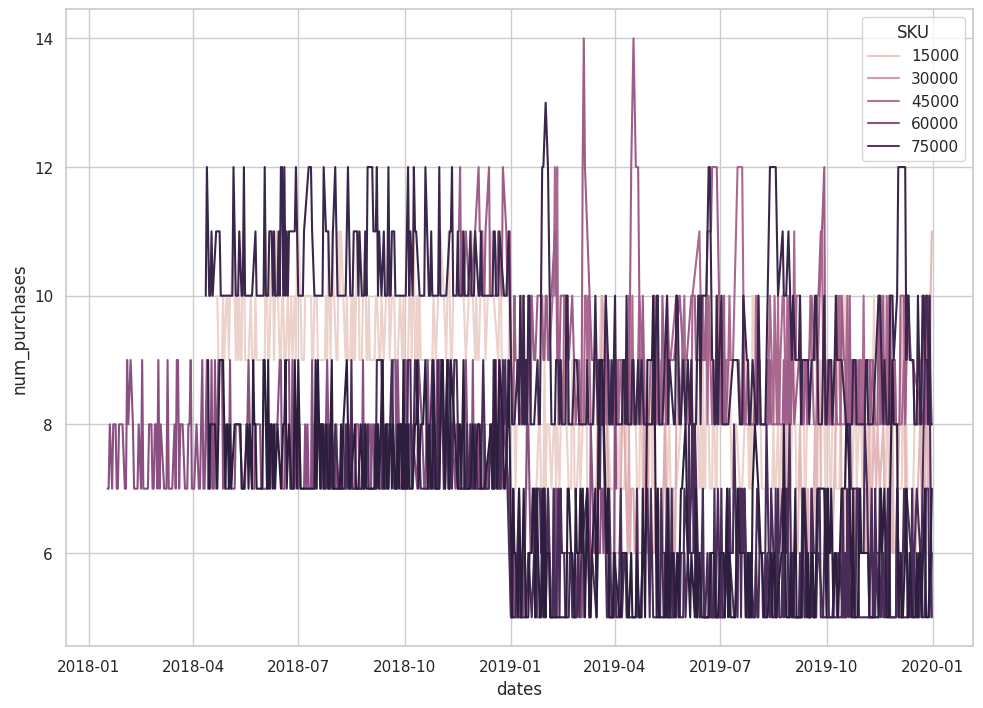

In [ ]:
sns.lineplot(data=df_1510003, x="dates", y="num_purchases", hue='SKU')

<Axes: xlabel='dates', ylabel='price_per_sku'>

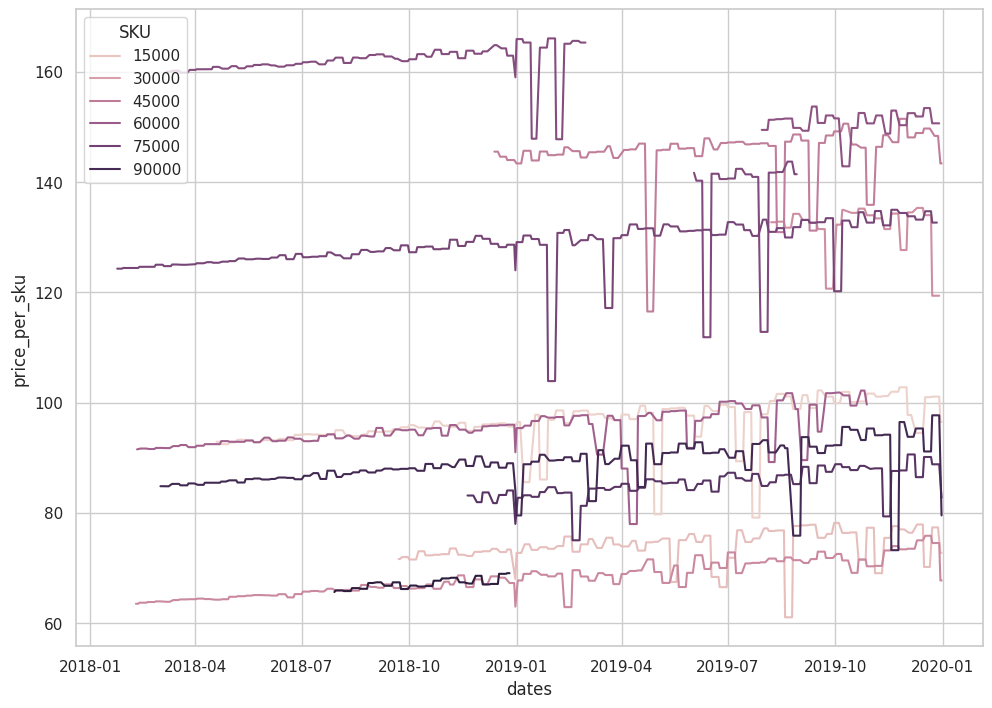

In [ ]:
sns.lineplot(data=df_1510002, x="dates", y='price_per_sku', hue='SKU')

<Axes: xlabel='num_purchases', ylabel='price_per_sku'>

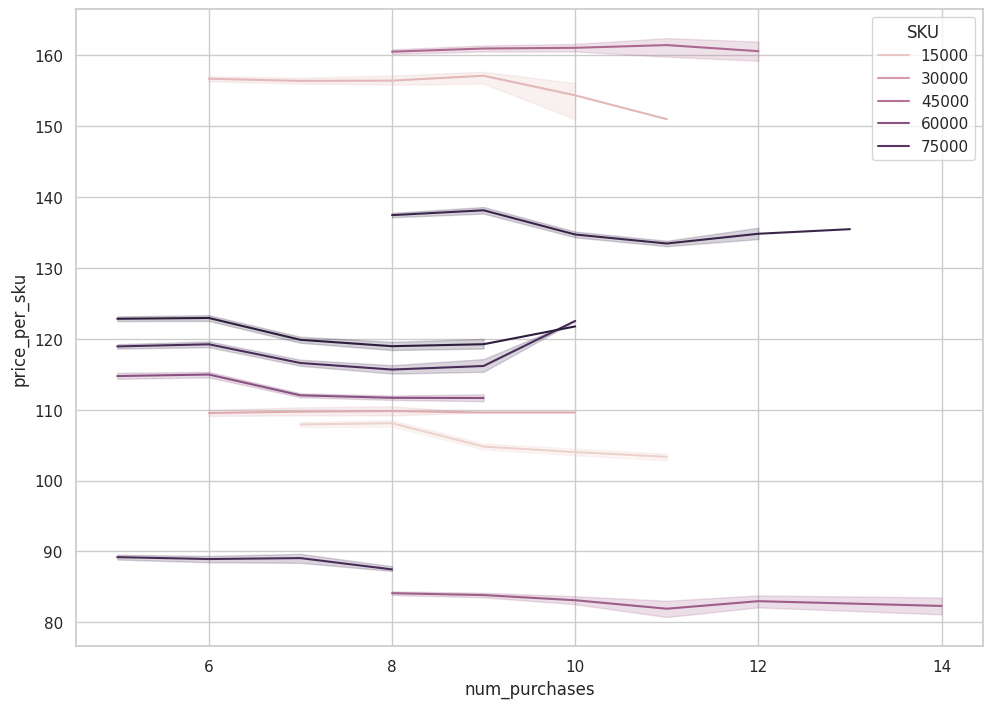

In [ ]:
sns.lineplot(data=df_1510003, x="num_purchases", y='price_per_sku', hue='SKU')

Похоже, что количество покупок в данном случае - темпоральный точечный процесс. Эластичность центы от количества покупок выглядит логично, чем ниже цена, тем больше покупают. В некоторых случаях зависимость близка к линейной.

In [7]:
concatenated_array = np.concatenate((ZX10208_df.SKU.unique(), df_1510001.SKU.unique(), df_1510002.SKU.unique(), df_1510003.SKU.unique()))
len(set(concatenated_array)), len(concatenated_array)

(39, 39)

Вхождения категорий товаров в разных датасетах отсутствуют

In [ ]:
def calculate_time_step(series):
    return series.diff().mode().iloc[0]
result0, result1 = ZX10208_df.groupby('SKU')['dates'].agg(calculate_time_step), df_1510001.groupby('SKU')['dates'].agg(calculate_time_step),
result2, result3= df_1510002.groupby('SKU')['dates'].agg(calculate_time_step), df_1510003.groupby('SKU')['dates'].agg(calculate_time_step)
result0, result1, result2, result3

(SKU
 59567   1 days
 82947   1 days
 Name: dates, dtype: timedelta64[ns],
 SKU
 27240   1 days
 27885   1 days
 34130   1 days
 36108   1 days
 39665   1 days
 40194   1 days
 45164   1 days
 48671   1 days
 49596   1 days
 59631   1 days
 63995   1 days
 70252   1 days
 70315   1 days
 72449   1 days
 Name: dates, dtype: timedelta64[ns],
 SKU
 10334   1 days
 17812   1 days
 36096   1 days
 38767   1 days
 43678   1 days
 57561   1 days
 64619   1 days
 68211   1 days
 69997   1 days
 72784   1 days
 83329   1 days
 90611   1 days
 98255   1 days
 Name: dates, dtype: timedelta64[ns],
 SKU
 11050   1 days
 19632   1 days
 24125   1 days
 49661   1 days
 54404   1 days
 60870   1 days
 80308   1 days
 80631   1 days
 84395   1 days
 89272   1 days
 Name: dates, dtype: timedelta64[ns])

Временной шаг равномерный 1 день

In [ ]:
promo_1510002['date'] = promo_1510002.to_datetime(df['date'])
promo_1510002['year'] = promo_1510002['date'].dt.isocalendar().year
df['week_num'] = df['date'].dt.isocalendar().week
df['week_start'] = df.apply(lambda x: x['date'] - pd.Timedelta(days=x['date'].dayofweek), axis=1)
df_expanded = df.loc[df.index.repeat(7)].copy()
df_expanded['date'] = df_expanded.groupby(level=0)['week_start'].apply(lambda x: pd.date_range(start=x.iloc[0], periods=7, freq='D'))
df_expanded = df_expanded.reset_index(drop=True)
df_expanded = df_expanded.drop(['year', 'week_num', 'week_start'], axis=1)

(SKU
 59567    156
 82947    103
 Name: dates, dtype: int64,
 SKU
 27240    121
 27885    253
 34130    312
 36108    265
 39665    354
 40194    267
 45164    425
 48671    305
 49596    184
 59631    183
 63995    312
 70252    480
 70315    429
 72449     50
 Name: dates, dtype: int64,
 SKU
 10334    453
 17812    317
 36096    102
 38767    478
 43678    261
 57561    437
 64619    109
 68211    262
 69997     63
 72784    498
 83329    293
 90611    469
 98255     98
 Name: dates, dtype: int64,
 SKU
 11050    441
 19632     92
 24125     52
 49661    226
 54404    272
 60870    328
 80308    387
 80631    170
 84395    446
 89272    437
 Name: dates, dtype: int64)

Длины массивов по категориям товаров разные, как и начало - конец временного диапазона

# Fitch extraction

In [8]:
all_data = pd.concat([ZX10208_df, df_1510001,
                      df_1510002, df_1510003])

In [9]:
all_data.reset_index(inplace=True, drop=True)
all_data

,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,59567,169.190,3
1,2018-04-24,59567,171.710,3
2,2018-04-27,59567,174.040,3
3,2018-04-30,59567,175.210,1
4,2018-05-03,59567,176.380,2
...,...,...,...,...
10885,2019-12-27,49661,165.978,10
10886,2019-12-28,49661,165.978,9
10887,2019-12-29,49661,165.978,10
10888,2019-12-30,49661,159.205,8


In [238]:
def week_num_to_date(year, week_num):
  return date.fromisocalendar(year, week_num, 1)

def year_week_processing(data: pd.DataFrame)->pd.DataFrame:
  data['year'] = pd.to_datetime(data['year']).dt.year
  data['dates'] = data.apply(lambda row: week_num_to_date(int(row['year']),
                                                                          int(row['week_num'])), axis=1)
  data['dates'] = pd.to_datetime(data['dates'])
  data.set_index('dates', inplace=True)
  data.sort_index(inplace=True)
  data = data.resample('D').ffill()
  data.reset_index(inplace=True)
  return data

promo_1510002=year_week_processing(promo_1510002)

In [241]:
promo_1510002

,dates,year,week_num,SKU,discount
0,2018-12-31,2019,1,90611,0.9
1,2019-01-01,2019,1,90611,0.9
2,2019-01-02,2019,1,90611,0.9
3,2019-01-03,2019,1,90611,0.9
4,2019-01-04,2019,1,90611,0.9
...,...,...,...,...,...
353,2019-12-19,2019,51,17812,0.9
354,2019-12-20,2019,51,17812,0.9
355,2019-12-21,2019,51,17812,0.9
356,2019-12-22,2019,51,17812,0.9


In [239]:
def week_num_to_date(year, week_num):
    year = int(year)
    first_day_of_year = datetime(year, 1, 1)
    days_to_add = (week_num - 1) * 7 - first_day_of_year.weekday()
    return first_day_of_year + pd.Timedelta(days=days_to_add)

def year_week_processing(data: pd.DataFrame) -> pd.DataFrame:
    data['year'] = pd.to_datetime(data['year'], format='%Y').dt.year
    data.drop_duplicates(inplace=True)
    data['dates'] = data.apply(lambda row: week_num_to_date(row['year'], row['week_num']), axis=1)
    new_dates = pd.date_range(data['dates'].min(), data['dates'].max(), freq='D')
    processed_data = pd.DataFrame(new_dates, columns=['dates'])
    processed_df = pd.merge(processed_data, data, on='dates', how='left')
    processed_df.drop(['year', 'week_num'], axis=1, inplace=True)
    processed_df['SKU']=processed_df['SKU'].ffill()
    processed_df['ret_net_code'] = processed_df.groupby('SKU')['ret_net_code'].ffill()
    processed_df['price_per_sku'] = processed_df.groupby('SKU')['price_per_sku'].ffill()
    processed_df['SKU'] = processed_df['SKU'].astype(int)
    processed_df['ret_net_code'] = processed_df['ret_net_code'].astype(int)

    return processed_df

conc_df = year_week_processing(conc_df)

In [243]:
conc_df = conc_df.rename(columns={'price_per_sku': 'ret_price'})

# Predictions and evaluate

In [280]:
df = all_data.copy()
df['num_purchases_next_day'] = df.groupby('SKU')['num_purchases'].shift(-1)
df.dropna(subset=['num_purchases_next_day'], inplace=True)
forecasts = []
for sku, group in df.groupby('SKU'):
    X = group[['price_per_sku', 'num_purchases']]
    y = group['num_purchases_next_day']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        shuffle=False, random_state=1)
    model = LinearRegression()
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)
    #y_pred = y_pred.round().astype(int)
    forecast = X_test.copy()
    forecast['num_purchases_next_day'] = y_test
    forecast['predicted'] = y_pred
    forecast['SKU'] = sku
    forecast = forecast.merge(group[['dates', 'price_per_sku', 'num_purchases']],
                              how='left')
    forecast.rename(columns={'price_per_sku': 'prev_price',
                             'num_purchases': 'prev_num_purchases'}, inplace=True)
    forecasts.append(forecast)

forecasts_df = pd.concat(forecasts)
forecasts_df.reset_index(inplace=True, drop=True)

rmse = mean_squared_error(forecasts_df['num_purchases_next_day'],
                          forecasts_df['predicted'], squared=False)
mae = mean_absolute_error(forecasts_df['num_purchases_next_day'],
                          forecasts_df['predicted'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

print(forecasts_df.isna().sum())

RMSE: 0.9655487171621437
MAE: 0.7562322451183265
prev_price                0
prev_num_purchases        0
num_purchases_next_day    0
predicted                 0
SKU                       0
dates                     0
dtype: int64


# Price recovery

In [307]:
RMSE_list = []
sku_list = []
for sku, group in forecasts_df.groupby('SKU'):
  X_train = group['prev_num_purchases']
  y_train = group['prev_price']
  model = LinearRegression()
  model.fit(X_train.values.reshape(-1, 1), y_train.values)
  y_pred = model.predict(group['predicted'].values.reshape(-1, 1))
  rmse = mean_squared_error(y_train[1:], y_pred[:-1], squared=False)
  mae = mean_absolute_error(y_train[1:], y_pred[:-1])
  RMSE_list.append(rmse)
  sku_list.append(sku)
  print(f"SKU: {sku}, RMSE:", rmse)
  print("MAE:", mae)
print(f' Mean RMSE: {np.mean(RMSE_list)}, std RMSE: {np.std(RMSE_list)}')

SKU: 10334, RMSE: 2.8558784958993884
MAE: 1.9930480629823644
SKU: 11050, RMSE: 1.5121524190853213
MAE: 1.271108925971932
SKU: 17812, RMSE: 2.127221049495297
MAE: 1.0818833430900026
SKU: 19632, RMSE: 1.1911153323902832
MAE: 0.7527283506102601
SKU: 24125, RMSE: 0.6627350239147444
MAE: 0.5877452398066487
SKU: 27240, RMSE: 1.0908443268545982
MAE: 1.0087229218660925
SKU: 27885, RMSE: 1.130883298166231
MAE: 0.9397107696882564
SKU: 34130, RMSE: 1.4963037401165042
MAE: 1.1861380230829526
SKU: 36096, RMSE: 3.581696570421044
MAE: 2.7584403235020325
SKU: 36108, RMSE: 1.292265815108892
MAE: 1.0851257888489587
SKU: 38767, RMSE: 1.5493851793805218
MAE: 1.2572997604260752
SKU: 39665, RMSE: 1.2445944014450467
MAE: 0.9123918254999744
SKU: 40194, RMSE: 1.1054813391382674
MAE: 0.8382790058316979
SKU: 43678, RMSE: 3.2022138024277176
MAE: 2.1177940600550893
SKU: 45164, RMSE: 1.3442146294179664
MAE: 1.223316975533794
SKU: 48671, RMSE: 1.3281047939581156
MAE: 1.1427661232860196
SKU: 49596, RMSE: 1.5509807251

# Summary

Mean by SKU RMSE: **1.91**